# Distributed haloes cutter
<b>Author</b>: Natalie B. Hogg

We use `lenstronomy` to create an image produced by the so-called "distributed haloes" model, where we have a main lens modelled by an EPL profile, with a large number of NFW haloes along the line-of-sight, both in front of and behind the main lens. We draw the positions of the haloes from a plectrum-shaped volume whose radius is dependent on the number density of haloes and the comoving distances from observer to halo and observer to source. We obtain the number density of the haloes and their masses from a halo mass function computed using `colossus`. We use the multi-plane lensing functionality of `lenstronomy` to place the haloes along the line-of-sight.

We create a mock image that would be observed in this situation, and attempt to fit it with a model which includes an EPL main lens plus line-of-sight shear. We aim to show that the MCMC can correctly recover the predicted LOS shears. We find that a number of haloes break the tidal approximation and induce a flexion-like residual in the reconstructed image. With these beyond-tidal haloes removed from the population, the LOS shears are recovered perfectly.

**This notebook loads the saved haloes and removes problematic ones, recomputes the shears and saves the surviving sample to a new file**.

## Contents <a name="contents"></a>
1. [Set up](#setup)
2. [Load data](#load)
3. [Compute the shears](#predict_shears)

## Set up <a name="setup"></a>

### Import packages

In [1]:
# computation
import numpy as np
import pandas as pd
import random as r

# plotting
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams, rcParamsDefault
from mpl_toolkits import mplot3d

# cosmology
from colossus.cosmology import cosmology as colcos
from colossus.lss import mass_function
from colossus.halo import concentration
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import constants as const
from astropy import units as u

# monitoring
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

outpath  = r'/home/natalie/Documents/Projects/los_effects/figures/distributed_haloes/simple/' 

job_name = 'million'

### Import `lenstronomy` packages

In [2]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

### Useful functions

In [3]:
def show_palette(colour):
    # function for displaying colour palettes
    sns.set_style('whitegrid')
    hex2rgb = []
    for k in colour:
        h = k.lstrip('#')
        hex2rgb.append(tuple(int(h[i:i + 2], 16) / 255.0 for i in (0, 2, 4)))
    return sns.palplot(hex2rgb)

def ellipticity(phi, q):
    # transforms orientation angle phi and aspect ratio q into complex ellipticity modulii e1, e2
    e1 = (1 - q)/(1 + q)*np.cos(2*phi)
    e2 = (1 - q)/(1 + q)*np.sin(2*phi)
    return e1, e2

def colorbar(mappable):
    # makes handling colour bars in matplotlib much easier
    # thanks to Joseph Long! https://joseph-long.com/writing/colorbars/
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '5%', pad = 0.05)
    cbar = fig.colorbar(mappable, cax = cax)
    plt.sca(last_axes)
    return cbar

def distance_conversion(distance, conversion_type):
    # converts a distance *in Mpc* to Gpc, kpc, pc or m
    # careful! it doesn't sanity check your input
    if conversion_type == 'to Gpc':
        new_distance = distance/(10**3)
    elif conversion_type == 'to kpc':
        new_distance = distance*(10**3)
    elif conversion_type == 'to pc':
        new_distance = distance*(10**6)
    elif conversion_type == 'to m':
        new_distance = distance*(3.086*10**22)
    else:
        print('Unknown conversion type')
    return new_distance

def angle_conversion(angle, conversion_type):
    # converts an angle in arcsec to rad or rad to arcsec
    # careful! it doesn't sanity check your input
    conversion_factor = np.pi/(180*3600)
    if conversion_type == 'to arcsecs':
        new_angle = angle/conversion_factor
    elif conversion_type == 'to radians':
        new_angle = angle*conversion_factor
    else:
        print('Unknown conversion type')
    return new_angle

### Global plotting and display settings

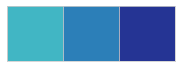

In [4]:
# contour plot colours
# thanks to colorbrewer for these palettes! https://colorbrewer2.org
green        = ['#a6dba0','#5aae61','#1b7837']
purple       = ['#c2a5cf', '#9970ab', '#762a83']
analogous    = ['#a0c3db', '#dbb7a0']
warm         = ['#fdcc8a', '#fc8d59', '#d7301f']
cool         = ['#41b6c4', '#2c7fb8', '#253494']

# have a look at a palette for example
show_palette(cool)

# set the seaborn style
sns.set_style('ticks')

# use TeX for plot labels
rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})

### Start the Universe

In [5]:
cosmology = {'id': 'planck18', 'H0': 67.4, 'Om': 0.315}

colcos.setCosmology(cosmology['id'])

cosmo = FlatLambdaCDM(H0 = cosmology['H0'], Om0 = cosmology['Om']) 

G_Newton   = const.G.value # 6.67*10**-11 [m^3 / kg s^2]
clight     = const.c.value # 299792458 [m / s]
clight_kms = clight/1000   # 299792.458 [km / s]
solar_mass = const.M_sun.value # 1.988*10**30 [kg]
parsec     = const.pc.value # 3.08567758*10**16 [m]

def dC(redshift):
    """
    Returns the comoving distance at a given redshift in Mpc.
    """
    distance = cosmo.comoving_distance(redshift).value
    return distance

def Hubble(redshift):
    """
    Returns H(z) for a given redshift in km/s/Mpc.
    """
    Hofz = cosmo.H(redshift).value
    return Hofz

def dA(z1, z2):
    """
    Returns angular diameter distance between two redshifts in Mpc.
    """
    distance = cosmo.angular_diameter_distance_z1z2(z1, z2).value
    return distance

def redshift_converter(object_distance, units):
    object_redshift = z_at_value(cosmo.comoving_distance, object_distance*units, zmin = -0.0001, zmax=5.)
    return object_redshift

z_observer = 0.0
z_lens     = 0.5 
z_source   = 1.5

d_observer = 0.0
d_od       = dA(z_observer, z_lens)
d_os       = dA(z_observer, z_source)
d_ds       = dA(z_lens, z_source)

dc_source = dC(z_source)

print('\nThe Hubble parameter being used is {} km/s/Mpc.'.format(cosmo.h*100))
print('The redshifts of the observer, lens and the source are z = {}, z = {:.2} and z = {} respectively.'.format(z_observer, z_lens, z_source))
print('The distances between observer and lens, observer and source and lens and source are {:.2f} Mpc, {:.2f} Mpc and {:.2f} Mpc respectively.'.format(d_od, d_os, d_ds))


The Hubble parameter being used is 67.4 km/s/Mpc.
The redshifts of the observer, lens and the source are z = 0.0, z = 0.5 and z = 1.5 respectively.
The distances between observer and lens, observer and source and lens and source are 1300.92 Mpc, 1792.84 Mpc and 1012.28 Mpc respectively.


## Load the halo data <a name="load"> </a>

In [6]:
haloes_fits = Table.read(outpath + 'total_haloes_dataframe_' + job_name + '.fits')

haloes_dataframe = haloes_fits.to_pandas()

halo_number = len(haloes_dataframe)

halo_redshift_list = haloes_dataframe['z'].to_list()

kwargs_nfw = haloes_dataframe[['Rs', 'alpha_Rs', 'center_x', 'center_y']].to_dict('records')

In [7]:
maximum_convergence = 0.5
maximum_Del = 0.1

# split the halo dataframe into good and bad
discarded_haloes_dataframe = haloes_dataframe.loc[(haloes_dataframe['kappa'] > maximum_convergence) | (haloes_dataframe['Del'] > maximum_Del)]
surviving_haloes_dataframe = haloes_dataframe.loc[(haloes_dataframe['kappa'] <= maximum_convergence) & (haloes_dataframe['Del'] <= maximum_Del)]

discarded_halo_number = len(discarded_haloes_dataframe)
surviving_halo_number = len(surviving_haloes_dataframe)

# check the split is correct
assert discarded_halo_number + surviving_halo_number == halo_number

# get rid of the kappa os and Del
discarded_haloes_dataframe.drop(['kappa', 'Del'], axis = 1, inplace = True)
surviving_haloes_dataframe.drop(['kappa', 'Del'], axis = 1, inplace = True)

## Predict the LOS terms: surviving haloes <a name="predict_shears"></a>

[Back to contents](#contents)

In [8]:
# make a dataframe to save them
surviving_shears_dataframe = pd.DataFrame(columns = ['gamma1_os', 'gamma2_os', 'kappa_os',
                                                     'gamma1_od', 'gamma2_od', 'kappa_od',
                                                     'gamma1_ds', 'gamma2_ds', 'kappa_ds',
                                                     'gamma1_los', 'gamma2_los', 'kappa_los'])

# dummy row so we can write scalars directly to the df
surviving_shears_dataframe = surviving_shears_dataframe.append(pd.Series('dummy'), ignore_index=True)

### Get the os component

In [9]:
# get the kwargs of the surviving haloes
surviving_halo_redshift_list = surviving_haloes_dataframe['z'].to_list()

# get the parameters needed for the lenstronomy kwargs and convert to list of dicts
kwargs_surviving_nfw = surviving_haloes_dataframe[['Rs', 'alpha_Rs', 
                                                   'center_x', 'center_y']].to_dict('records')

os_lens_model = LensModel(lens_model_list = ['NFW'], z_source = z_source)

gamma1_os = []
gamma2_os = []
kappa_os  = []
alpha1_os = []
alpha2_os = []


print('\nGetting os convergence and shear')
for i in tqdm(range(len(surviving_halo_redshift_list))):
    gamma_os = os_lens_model.gamma(x = 0.0, y = 0.0, kwargs = [kwargs_surviving_nfw[i]])
    gamma1_os.append(float(gamma_os[0]))
    gamma2_os.append(float(gamma_os[1]))
    kappa_os_calc = os_lens_model.kappa(x = 0.0, y = 0.0, kwargs = [kwargs_surviving_nfw[i]])
    kappa_os.append(float(kappa_os_calc))
    alpha_os = os_lens_model.alpha(x = 0.0, y = 0.0, kwargs = [kwargs_surviving_nfw[i]])
    alpha1_os.append(float(alpha_os[0]))
    alpha2_os.append(float(alpha_os[1]))
    
expected_gamma_os_1 = sum(gamma1_os)
expected_gamma_os_2 = sum(gamma2_os)
expected_kappa_os   = sum(kappa_os)
alpha1_os = sum(alpha1_os)
alpha2_os = sum(alpha2_os)

surviving_shears_dataframe['gamma1_os'] = expected_gamma_os_1
surviving_shears_dataframe['gamma2_os'] = expected_gamma_os_2
surviving_shears_dataframe['kappa_os'] = expected_kappa_os
surviving_shears_dataframe['alpha1_os'] = alpha1_os
surviving_shears_dataframe['alpha2_os'] = alpha2_os


Getting os convergence and shear


  0%|          | 0/10474 [00:00<?, ?it/s]

### Get the od component

In [10]:
foreground_haloes_dataframe = surviving_haloes_dataframe[surviving_haloes_dataframe['z'].between(z_observer, z_lens)]

foreground_halo_redshift_list = foreground_haloes_dataframe['z'].to_list()

kwargs_foreground_nfw = foreground_haloes_dataframe[['Rs', 'alpha_Rs', 
                                                     'center_x', 'center_y']].to_dict('records')

def foreground_distance(z_halo):
    d_hd = dA(z_halo, z_lens)
    d_hs = dA(z_halo, z_source)
    distance = (d_os*d_hd)/(d_od*d_hs)
    return distance

od_lens_model = LensModel(lens_model_list = ['NFW'], z_source = z_source)

gamma1_od = []
gamma2_od = []
kappa_od  = []
alpha1_od = []
alpha2_od = []

print('\nGetting od convergence and shear')
for i in tqdm(range(len(foreground_halo_redshift_list))):
    gamma_od = od_lens_model.gamma(x = 0.0, y = 0.0, kwargs = [kwargs_foreground_nfw[i]])
    kappa_od_calc = od_lens_model.kappa(x = 0.0, y = 0.0, kwargs = [kwargs_foreground_nfw[i]])
    gamma1_od.append(float(gamma_od[0]))
    gamma2_od.append(float(gamma_od[1]))
    kappa_od.append(float(kappa_od_calc))    
    alpha_od = od_lens_model.alpha(x = 0.0, y = 0.0, kwargs = [kwargs_foreground_nfw[i]])
    alpha1_od.append(float(alpha_od[0]))
    alpha2_od.append(float(alpha_od[1]))
        
foreground_distance_combination = [foreground_distance(i) for i in foreground_halo_redshift_list]
    
expected_gamma_od_1 = sum(np.multiply(gamma1_od, foreground_distance_combination))
expected_gamma_od_2 = sum(np.multiply(gamma2_od, foreground_distance_combination))
expected_kappa_od = sum(np.multiply(kappa_od, foreground_distance_combination))
alpha1_od = sum(np.multiply(alpha1_od, foreground_distance_combination))
alpha2_od = sum(np.multiply(alpha2_od, foreground_distance_combination))

surviving_shears_dataframe['gamma1_od'] = expected_gamma_od_1
surviving_shears_dataframe['gamma2_od'] = expected_gamma_od_2
surviving_shears_dataframe['kappa_od'] = expected_kappa_od

surviving_shears_dataframe['alpha1_od'] = alpha1_od
surviving_shears_dataframe['alpha2_od'] = alpha2_od


Getting od convergence and shear


  0%|          | 0/3839 [00:00<?, ?it/s]

### Get the ds component

In [11]:
background_haloes_dataframe = surviving_haloes_dataframe[surviving_haloes_dataframe['z'].between(z_lens, z_source)]

background_halo_redshift_list = background_haloes_dataframe['z'].to_list()

kwargs_background_nfw = background_haloes_dataframe[['Rs', 'alpha_Rs', 
                                                     'center_x', 'center_y']].to_dict('records')

def background_distance(z_halo):
    d_db = dA(z_lens, z_halo)
    d_ob = dA(z_observer, z_halo)
    distance = (d_os*d_db)/(d_ob*d_ds)
    return distance


ds_lens_model = LensModel(lens_model_list = ['NFW'], z_source = z_source)

gamma1_ds = []
gamma2_ds = []
kappa_ds  = []

print('\nGetting ds convergence and shear')
for i in tqdm(range(len(background_halo_redshift_list))):
    gamma_ds = ds_lens_model.gamma(x = 0.0, y = 0.0, kwargs = [kwargs_background_nfw[i]])
    gamma1_ds.append(float(gamma_ds[0]))
    gamma2_ds.append(float(gamma_ds[1]))
    kappa_ds_calc = ds_lens_model.kappa(x = 0.0, y = 0.0, kwargs = [kwargs_background_nfw[i]])
    kappa_ds.append(float(kappa_ds_calc))
    
background_distance_combination = [background_distance(i) for i in background_halo_redshift_list]
    
expected_gamma_ds_1 = sum(np.multiply(gamma1_ds, background_distance_combination))
expected_gamma_ds_2 = sum(np.multiply(gamma2_ds, background_distance_combination))
expected_kappa_ds = sum(np.multiply(kappa_ds, background_distance_combination))

surviving_shears_dataframe['gamma1_ds'] = expected_gamma_ds_1
surviving_shears_dataframe['gamma2_ds'] = expected_gamma_ds_2
surviving_shears_dataframe['kappa_ds'] = expected_kappa_ds


Getting ds convergence and shear


  0%|          | 0/6635 [00:00<?, ?it/s]

### Get the LOS component

In [12]:
expected_gamma_LOS_1 = expected_gamma_os_1 + expected_gamma_od_1 - expected_gamma_ds_1
expected_gamma_LOS_2 = expected_gamma_os_2 + expected_gamma_od_2 - expected_gamma_ds_2
expected_kappa_LOS   = expected_kappa_os + expected_kappa_od - expected_kappa_ds

surviving_shears_dataframe['gamma1_los'] = expected_gamma_LOS_1
surviving_shears_dataframe['gamma2_los'] = expected_gamma_LOS_2
surviving_shears_dataframe['kappa_los'] = expected_kappa_LOS

In [13]:
print('\nThe predicted shear components with problematic haloes removed are:')
print('gamma_os  = ({:.3e}, {:.3e})'.format(expected_gamma_os_1, expected_gamma_os_2))
print('gamma_od  = ({:.3e}, {:.3e})'.format(expected_gamma_od_1, expected_gamma_od_2))
print('gamma_ds  = ({:.3e}, {:.3e})'.format(expected_gamma_ds_1, expected_gamma_ds_2))
print('gamma_LOS = ({:.3e}, {:.3e})'.format(expected_gamma_LOS_1, expected_gamma_LOS_2))


The predicted shear components with problematic haloes removed are:
gamma_os  = (-9.991e-03, 3.409e-02)
gamma_od  = (1.307e-03, 8.465e-03)
gamma_ds  = (-7.143e-03, 1.179e-02)
gamma_LOS = (-1.541e-03, 3.076e-02)


In [14]:
print('\nThe predicted convergence components are:')
print('kappa_os  = {:.3e}.'.format(expected_kappa_os))
print('kappa_od  = {:.3e}.'.format(expected_kappa_od))
print('kappa_ds  = {:.3e}.'.format(expected_kappa_ds))
print('kappa_LOS = {:.3e}.'.format(expected_kappa_LOS))


The predicted convergence components are:
kappa_os  = 3.049e-01.
kappa_od  = 2.770e-02.
kappa_ds  = 1.617e-01.
kappa_LOS = 1.709e-01.


# Save the final dataframes to file

In [15]:
# write haloes to fits
surviving_haloes_fits = Table.from_pandas(surviving_haloes_dataframe)
surviving_haloes_fits.write(outpath + 'surviving_haloes_dataframe_' + job_name + '.fits', overwrite = True)

# write shears to csv
surviving_shears_dataframe.to_csv(outpath + 'surviving_shears_dataframe_' + job_name + '.csv', index = False)

[Back to contents](#contents)